Hip Dysplasia Classification

Experiment One
    - Based on code from Feb 4, 2020 (commit e8a42b95208d73a8b4da5718ea6fe76e721fb2d3)

Imports 

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import time
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from data_loader import DataGenerator

Model Architecture is a ResNET 

In [10]:
def resnet2(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS):

    he_init = keras.initializers.he_normal(seed=None)

    def res_net_block(input_data, filters, kernel_size, strides=1):
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu', kernel_initializer=he_init)(input_data)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, kernel_initializer=he_init)(x)
        x = layers.BatchNormalization()(x)
        
        if(strides == 2):  # add linear projection residual shortcut connection to match changed dims
            input_data = layers.Conv2D(filters, 1, strides=strides, padding='same', activation=None, kernel_initializer=he_init)(input_data)
        x = layers.Add()([x, input_data])
        x = layers.Activation('relu')(x)
        return x

    inputs = keras.Input(shape=(HEIGHT, WIDTH, CHANNELS))
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=he_init)(inputs)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=he_init)(x)
    x = layers.MaxPooling2D(3)(x)

    num_filters = 64
    for stage in range(3):
        if(stage == 0):
            x = res_net_block(x, num_filters, 3)
        else:
            x = res_net_block(x, num_filters, 3, strides=2)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        x = res_net_block(x, num_filters, 3)
        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1000, activation='relu', kernel_initializer=he_init)(x)
    outputs = layers.Dense(NUM_OUTPUTS, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

Classification 

In [11]:
def Classify():
  
  # Training Parameters
  epochs = 50
  batch_size = 16 
  test_batch_size = 8

  # Import Dataset
  path = '../../../../data/hip_images_marta/'
  imagedir = path
  anglecsv = path + 'final_data.csv'
  data = DataGenerator(imagedir=imagedir, anglecsv=anglecsv, width=512, height=512)
  x_train = data.x_train
  y_train = data.y_train
  x_test = data.x_test
  y_test = data.y_test
  print("Training DataSet: " + str(x_train.shape) + " " + str(y_train.shape))
  print("Test DataSet: " + str(x_test.shape) + " " + str(y_test.shape))
  
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).shuffle(1000)
  train_dataset = train_dataset.repeat()
    
  valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(test_batch_size).shuffle(1000)
  valid_dataset = valid_dataset.repeat()

  def lr_schedule(epoch):
      """ Learning Rate Schedule. Learning rate is scheduled to be reduced 
      after 80, 120, 160, 180 epochs. Called automatically every epoch as 
      part of callbacks during training. """

      lr = 1e-3
      if epoch > 180:
          lr *= 0.5e-3
      elif epoch > 160:
          lr *= 1e-3
      elif epoch > 120:
          lr *= 1e-2
      elif epoch > 80:
          lr *= 1e-1
      print('Learning rate: ', lr)
      return lr

  # Network Parameters
  WIDTH = data.WIDTH
  HEIGHT = data.HEIGHT
  CHANNELS = 1
  NUM_OUTPUTS = 2

  model = resnet2(HEIGHT, WIDTH, CHANNELS, NUM_OUTPUTS);
  model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.summary()

  # Prepare callbacks
  lr_scheduler = LearningRateScheduler(lr_schedule)
  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=1, patience=5, min_lr=0.5e-6)
  callbacks = [lr_reducer, lr_scheduler]

  start = time.time();
  history = model.fit(train_dataset, 
          epochs=epochs, 
          steps_per_epoch=200,
          validation_data=valid_dataset,
          validation_steps = 10, 
          callbacks=callbacks)
  
  evaluation = model.evaluate(x_test, y_test, verbose=1)
  end = time.time()

  print('Classify Summary: Accuracy: %.2f Time Elapsed: %.2f seconds' % (evaluation[1], (end - start)) )

  # Plot Accuracy 
  plt.plot(history.history["categorical_accuracy"])
  plt.plot(history.history["val_categorical_accuracy"])
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.title('Classify Summary: Accuracy: %.2f Time Elapsed: %.2f seconds' % (evaluation[1], (end - start)))
  plt.legend(["Train Accuracy", "Test Accuracy"], loc="upper left")
  plt.show()

  import datetime
  file_time = datetime.datetime.today().strftime('_%Y-%m-%d__%I-%M')

  import os
  if not os.path.exists('results/'):
    os.makedirs('results/')

  plt.savefig('results/classifier_' + file_time + '.png')
  model.save('results/classifier_' + file_time + '.h5') 

  0%|▏                                                                                | 2/1079 [00:00<01:07, 15.90it/s]

Loading and formating image data ....


100%|██████████████████████████████████████████████████████████████████████████████| 1079/1079 [06:30<00:00,  2.77it/s]


Loading and formating image data: Complete
Data size: Input Data (863, 512, 512, 1)  Truth Data: (863, 2)
Training DataSet: (863, 512, 512, 1) (863, 2)
Test DataSet: (216, 512, 512, 1) (216, 2)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 18496       conv2d[0][0]                     
____________________________________________________________________________

Epoch 1/50
Learning rate:  0.001
200/200 [==============================] - 89s 333ms/step - loss: 1.7538 - categorical_accuracy: 0.5576 - val_loss: 0.7405 - val_categorical_accuracy: 0.4375
Epoch 2/50
Learning rate:  0.001
200/200 [==============================] - 54s 269ms/step - loss: 0.6346 - categorical_accuracy: 0.6611 - val_loss: 1.0740 - val_categorical_accuracy: 0.5500
Epoch 3/50
Learning rate:  0.001
200/200 [==============================] - 54s 268ms/step - loss: 0.5752 - categorical_accuracy: 0.7054 - val_loss: 0.8126 - val_categorical_accuracy: 0.5375
Epoch 4/50
Learning rate:  0.001
200/200 [==============================] - 55s 274ms/step - loss: 0.5091 - categorical_accuracy: 0.7434 - val_loss: 0.6307 - val_categorical_accuracy: 0.7000
Epoch 5/50
Learning rate:  0.001
200/200 [==============================] - 54s 272ms/step - loss: 0.4411 - categorical_accuracy: 0.7995 - val_loss: 0.2452 - val_categorical_accuracy: 0.8875
Epoch 6/50
Learning rate:  0.001
200/200 [===

200/200 [==============================] - 58s 288ms/step - loss: 1.0491e-06 - categorical_accuracy: 1.0000 - val_loss: 1.2440 - val_categorical_accuracy: 0.8500
Epoch 44/50
Learning rate:  0.001
200/200 [==============================] - 60s 299ms/step - loss: 9.4471e-07 - categorical_accuracy: 1.0000 - val_loss: 1.2045 - val_categorical_accuracy: 0.8375
Epoch 45/50
Learning rate:  0.001
200/200 [==============================] - 57s 286ms/step - loss: 7.3957e-07 - categorical_accuracy: 1.0000 - val_loss: 1.2678 - val_categorical_accuracy: 0.8500
Epoch 46/50
Learning rate:  0.001
200/200 [==============================] - 55s 274ms/step - loss: 8.1955e-07 - categorical_accuracy: 1.0000 - val_loss: 1.1747 - val_categorical_accuracy: 0.8625
Epoch 47/50
Learning rate:  0.001
200/200 [==============================] - 55s 273ms/step - loss: 6.9658e-07 - categorical_accuracy: 1.0000 - val_loss: 1.2447 - val_categorical_accuracy: 0.8875
Epoch 48/50
Learning rate:  0.001
200/200 [===========

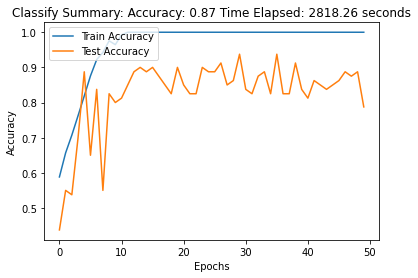

<Figure size 432x288 with 0 Axes>

In [12]:
Classify()